# Week Four: Evaluation Metrics for Classification

Starting with the same model from last week (for churn prediction) we will focus on evaluation metrics.

In [86]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Data import and prep

In [2]:
customer_data = pd.read_csv('data/telco_customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
customer_data.columns = customer_data.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(customer_data.dtypes[customer_data.dtypes == 'object'].index)

for c in categorical_columns:
    customer_data[c] = customer_data[c].str.lower().str.replace(' ', '_')

In [4]:
customer_data['totalcharges'] = pd.to_numeric(customer_data['totalcharges'], errors='coerce') 

In [5]:
customer_data['totalcharges'] = customer_data['totalcharges'].fillna(0) # filling missing values may not be the best approach

In [6]:
customer_data['churn'] = (customer_data['churn'] == 'yes').astype(int)

In [7]:
np.random.seed(42)

df_full_train, df_test = train_test_split(customer_data, test_size=0.2, random_state=1)

df_train, df_val  = train_test_split(df_full_train, test_size=0.25, random_state=1) # 25% here means it will be 20% of the overall data set

len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

### Split data and train model

In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical_features = ['tenure', 'monthlycharges', 'totalcharges']
categorical_features = [x for x in df_full_train.columns.tolist() if x not in numerical_features and x != 'churn' and x != 'customerid']

In [10]:
train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')

X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

churn_decision = (y_pred >= 0.5)

(churn_decision == y_val).mean()

0.8034066713981547

## Evaluation Metrics

### 4.2 Accuracy and dummy model

#### Answer the question: is 80% good enough?

- evaluate the model with different thresholds
- check accuracy of the dummy baseline

#### correct decisions / number of customers == accuracy

In [11]:
number_of_customers = len(y_val)
correct_answers = (y_val == churn_decision).sum()

correct_answers / number_of_customers

# rememeber we can also use the .mean() here because they are binary

0.8034066713981547

In [12]:
thresholds = np.linspace(0,1,21)

scores = []

for threshold in thresholds:
    churn_decision = (y_pred >= threshold)
    score = (churn_decision == y_val).mean()
    scores.append(score)

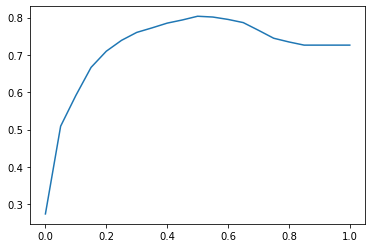

In [13]:
plt.plot(thresholds, scores)

We see that 0.5 does indeed give us the best accuracy.

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
# we can use this accuracy_score instead of calculating it ourself
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

If we look at the far end of the chart we see that for churn probability == that our accuracy is still relatively good (~70%) this would predict everyone as not churning but we know that is not representative. This is because we have more customers who do not churn in the data set than we have customers in the data set that churn (class inbalance)

So we can not only look at accuracy to understand our models performance.

### 4.3 Confusion Tables

- not affected by class in balance

- true positive (we predict churn and its correct)
- true negative (we predict they will not churn and its correct)
- false positive (we predict they will churn but they do not)
- false negative (we predict they will not churn but they do)

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

threshold = 0.5
predict_positive = (y_pred >= threshold)
predict_negative = (y_pred < threshold)

In [17]:
true_positive = (predict_positive & actual_positive).sum() # returns an array where both are positive
true_positive

210

In [18]:
true_negative = (predict_negative & actual_negative).sum()
true_negative

922

In [19]:
false_positive = (predict_positive & actual_negative).sum()
false_positive

101

In [20]:
false_negative = (predict_negative & actual_positive).sum()
false_negative

176

Lets now put all these values into a single table

In [21]:
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

For us we see a lot of false positive, people we think will churn so we send out promotions but the customer stays regardless. On the other hand false negative who we think will not churn and don't send them any promotion and therefore are unable to retain their business.

In [22]:
# another way we can show the accuracy is below
(true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

0.8034066713981547

### 4.4 Precision and Recall

**Precision:** the fraction of positive predictions that are correct

(tp / total positive ie true positive + false positive)

In [23]:
p = true_positive / (true_positive + false_positive)
p

0.6752411575562701

**Recall:** the fraction of incorrectly predicted positive examples

(tp / total positive ie true positive + false negative)

In [24]:
r = true_positive / (true_positive + false_negative)
r

0.5440414507772021

For 46% of people who are churning we failed to identify them.

When we look only at accuracy the model seems good but when we look closer for the case we want to use the model we are actually failing. We are sending many customers who probably would not churn promotions and missing some who will churn. Therefore precision and recall can be better metrics to look at when evaluating our model.

![confusion table]('images/confusion_table.png')

![Recall and precision]('images/recall_and_precision.png')

### ROC Curves

Receiving operating characteristic


**False positive rate (FPR)** = False Positive / (True negative + False positive)

**True positive rate (TPR)** = True Positive / (True positive + False negative)


We want the FPR to be as low as possible (meaning we want to minimise the amount false positive) and the TPR to be as high as possible (meaning to minimise the amount of false negative values)

In [25]:
tpr = true_positive / (true_positive + false_negative)
tpr

0.5440414507772021

In [26]:
fpr = false_positive / (false_positive + true_negative)
fpr

0.09872922776148582

Note that tpr is the same as our recall. An ROC curve looks at all thresholds and evaluates them.

In [27]:
thresholds = np.linspace(0, 1, 101)
scores = []


for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = false_negative = (predict_negative & actual_positive).sum()
    
    scores.append((t,tp,fp,fn, tn))
    

In [28]:
columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
scores_df = pd.DataFrame(scores, columns=columns)

In [29]:
scores_df['true_positive_rate'] = scores_df.true_positive / (scores_df.true_positive + scores_df.false_negative)
scores_df['false_positive_rate'] = scores_df.false_positive / (scores_df.false_positive + scores_df.true_negative)

In [30]:
scores_df[::10]

,threshold,true_positive,false_positive,false_negative,true_negative,true_positive_rate,false_positive_rate
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


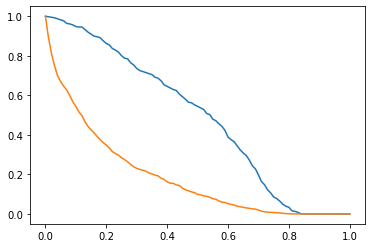

In [31]:
plt.plot(scores_df.threshold, scores_df['true_positive_rate'], label='TPR' )
plt.plot(scores_df.threshold, scores_df['false_positive_rate'], label='FPR' )

### Random model

In [32]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val)) # for each customer randomly predict if they will churn or not

In [33]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [34]:
def tpr_fpr_df(y_val, y_pred):
    thresholds = np.linspace(0, 1, 101)
    scores = []


    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = false_negative = (predict_negative & actual_positive).sum()

        scores.append((t,tp,fp,fn, tn))
        
    columns = ['threshold', 'true_positive', 'false_positive', 'false_negative', 'true_negative']
    scores_df = pd.DataFrame(scores, columns=columns)
    
    scores_df['true_positive_rate'] = scores_df.true_positive / (scores_df.true_positive + scores_df.false_negative)
    scores_df['false_positive_rate'] = scores_df.false_positive / (scores_df.false_positive + scores_df.true_negative)

    return scores_df

In [35]:
df_rand = tpr_fpr_df(y_val, y_rand)

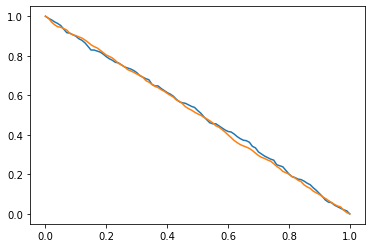

In [36]:
plt.plot(df_rand.threshold, df_rand['true_positive_rate'], label='TPR' )
plt.plot(df_rand.threshold, df_rand['false_positive_rate'], label='FPR' )

For these randomly assigned predictions we see its a straight line down.


### Ideal model

72% no churn and 28% churning. We order them so all non churning are first.

In [37]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [38]:
y_ideal = np.repeat([0,1], [num_neg, num_pos]) 
# repeats 0 for the number of negative and 1 for the positive in an array

In [39]:
y_ideal_pred = np.linspace(0, 1, len(y_val)) # ideal predictions for our classifier

In [40]:
((y_ideal_pred >= 0.72) == y_ideal).mean()

0.99361249112846

In [41]:
# now we created the ideal model we see accuracy is close to 100%
# (it can be 100% if you change to 0.726)
# we can use this to benchmark our model

df_ideal = tpr_fpr_df(y_ideal, y_ideal_pred)

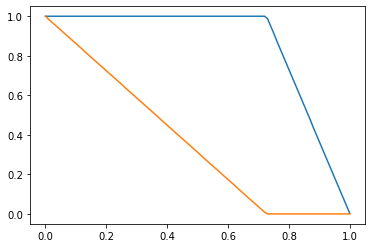

In [42]:
plt.plot(df_ideal.threshold, df_ideal['true_positive_rate'], label='TPR' )
plt.plot(df_ideal.threshold, df_ideal['false_positive_rate'], label='FPR' )

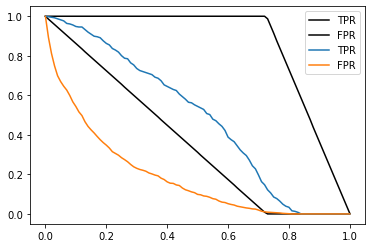

In [43]:
plt.plot(df_ideal.threshold, df_ideal['true_positive_rate'], label='TPR', color='black')
plt.plot(df_ideal.threshold, df_ideal['false_positive_rate'], label='FPR', color='black')
plt.plot(scores_df.threshold, scores_df['true_positive_rate'], label='TPR' )
plt.plot(scores_df.threshold, scores_df['false_positive_rate'], label='FPR' )
plt.legend()

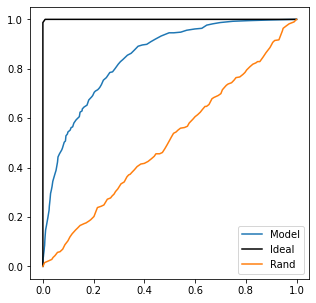

In [89]:
# normally square graph
plt.figure(figsize=(5,5))

plt.plot(scores_df['false_positive_rate'], scores_df['true_positive_rate'], label='Model')
plt.plot(df_ideal['false_positive_rate'], df_ideal['true_positive_rate'], label='Ideal', color='black')
plt.plot(df_rand['false_positive_rate'], df_rand['true_positive_rate'], label='Rand')
plt.legend()

Our model ideally  is towards the idea curve, if its below the random model baseline we have a mistake somewhere (probably need to flip positive and negative values)

We can also use this to compare different models.

AUC (area under the curve) tells us how good the classifier is.

Doing this with Sklearn

In [45]:
from sklearn.metrics import roc_curve

In [46]:
fpr, tpr, t = roc_curve(y_val, y_pred) # outputs tpr, fpr and thresholds

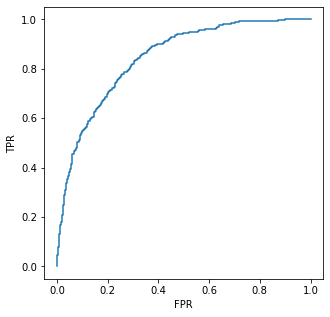

In [47]:
plt.figure(figsize=(5,5))

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(fpr, tpr, label='Model')

## 4.6 ROC AUC

Area Under the Curve is a useful metric for evaluating binary classification models.

As the ideal curve goes straight up and then across it would have the largest area under the curve (ie 1.0). We can therefore use the AUC to evaluate our model, ie a model with AUC of 0.9 would be more performant than one with 0.8. We look at how far it is from the random base line and the ideal model.

In [48]:
from sklearn.metrics import auc # measures auc for any curve not just roc

In [49]:
auc(fpr, tpr)

0.8438454408703447

In [50]:
# to check what auc has the ideal model
auc(df_ideal['false_positive_rate'], df_ideal['true_positive_rate'])

0.9999430203759136

In [51]:
# we can also get dirrectly to this metric with the following function from sklearn
from sklearn.metrics import roc_auc_score

In [52]:
roc_auc_score(y_val, y_pred)

0.8438454408703447

AUC tells us what is the probability of a randomly selected positive value has a higher score then a randomly selected negative value.


Probability(random_pos_value > random_neg_value)

In [53]:
# get negative and positive values split
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [54]:
import random

In [55]:
# randomly choose a negative and positive value
pos_idx = random.randint(0, len(pos) -1)
neg_idx = random.randint(0, len(neg) -1)

In [56]:
pos[pos_idx] > neg[neg_idx]

True

In [57]:
n = 100000
success = 0

for i in range(n):
    pos_idx = random.randint(0, len(pos) -1)
    neg_idx = random.randint(0, len(neg) -1)
    
    if pos[pos_idx] > neg[neg_idx]:
        success = success + 1
        
print(f'In 100,000 times we note that the chosen positive example is higher than the negative {int((success / n) * 100)} % of the time')

In 100,000 times we note that the chosen positive example is higher than the negative 84 % of the time


This tells us how well the model can order values.

We can also do this with Numpy

In [58]:
pos_ind = np.random.randint(0, len(pos), size=n) # here the second value is not inclusive
neg_ind = np.random.randint(0, len(pos), size=n)

In [59]:
auc_array = (pos[pos_ind] > neg[neg_ind]) # create boolean array
auc_array

array([ True,  True,  True, ..., False,  True,  True])

In [60]:
auc_array.mean()

0.84973

## 4.7 Cross Validation

Parameter Tuning - selecting the best parameter

k folds (number of times the data is split)

Say we split it into 3 we would then do the following:

 | train |  train | validate|
 | ------|--------|---------|
 |  1    |   2    |    3    |
 |  2    |   3    |    1    |
 |  3    |   1    |    2    |
 
 
 This way we can see how each parameter perform across different splits of the data.

In [61]:
def train(df, y_train):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    return dv, model

In [62]:
dv, model = train(df_train, y_train)

In [63]:
def predict(df, dv, model):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [64]:
y_preds = predict(df_val,dv, model)

In [66]:
from sklearn.model_selection import KFold

In [67]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [69]:
train_idx, val_idx = next(kfold.split(df_full_train)) 
# returns two array one fro training indexes and one for validation
# next creates a generator so we can then loop over it (here we just take the first loop)

In [70]:
len(train_idx), len(val_idx)

(5070, 564)

In [71]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [82]:
!pip install tqdm

In [83]:
from tqdm.auto import tqdm # times the loop iterations

In [87]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['churn'].values
    y_val = df_val['churn'].values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

0it [00:00, ?it/s]

In [88]:
scores

[0.8479398247539081,
 0.841089108910891,
 0.8557214756739697,
 0.8343428524401284,
 0.8232009925558312,
 0.8342657342657342,
 0.8412569195701727,
 0.8186669829222013,
 0.8454868830591373,
 0.8628449463883567]